# Module 2: Homework solutions

## Q1

In [1]:
import mlflow

mlflow.__version__

'1.26.1'

## Q2

In [2]:
!python preprocess_data.py --raw_data_path ./data --dest_path ./output

In [8]:
!cd output && ls -F |grep -v / | wc -l

       4


## Q3

In [23]:
import os
import pickle

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


def load_pickle(filename: str):
    with open(filename, "rb") as f_in:
        return pickle.load(f_in)


In [24]:
import mlflow
from train import *

data_path = './output'

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("hw-taxi-experiment")
mlflow.sklearn.autolog()

X_train, y_train = load_pickle(os.path.join(data_path, "train.pkl"))
X_valid, y_valid = load_pickle(os.path.join(data_path, "valid.pkl"))


with mlflow.start_run():
    rf = RandomForestRegressor(max_depth=10, random_state=0)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_valid)

    rmse = mean_squared_error(y_valid, y_pred, squared=False)
    mlflow.log_metric('rmse', rmse)

In [38]:
from mlflow.tracking import MlflowClient
from mlflow.entities import ViewType


MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

runs = client.search_runs(
    experiment_ids=1,
    run_view_type=ViewType.ACTIVE_ONLY,
)

print(len(runs[0].data.params))

17


## Q4

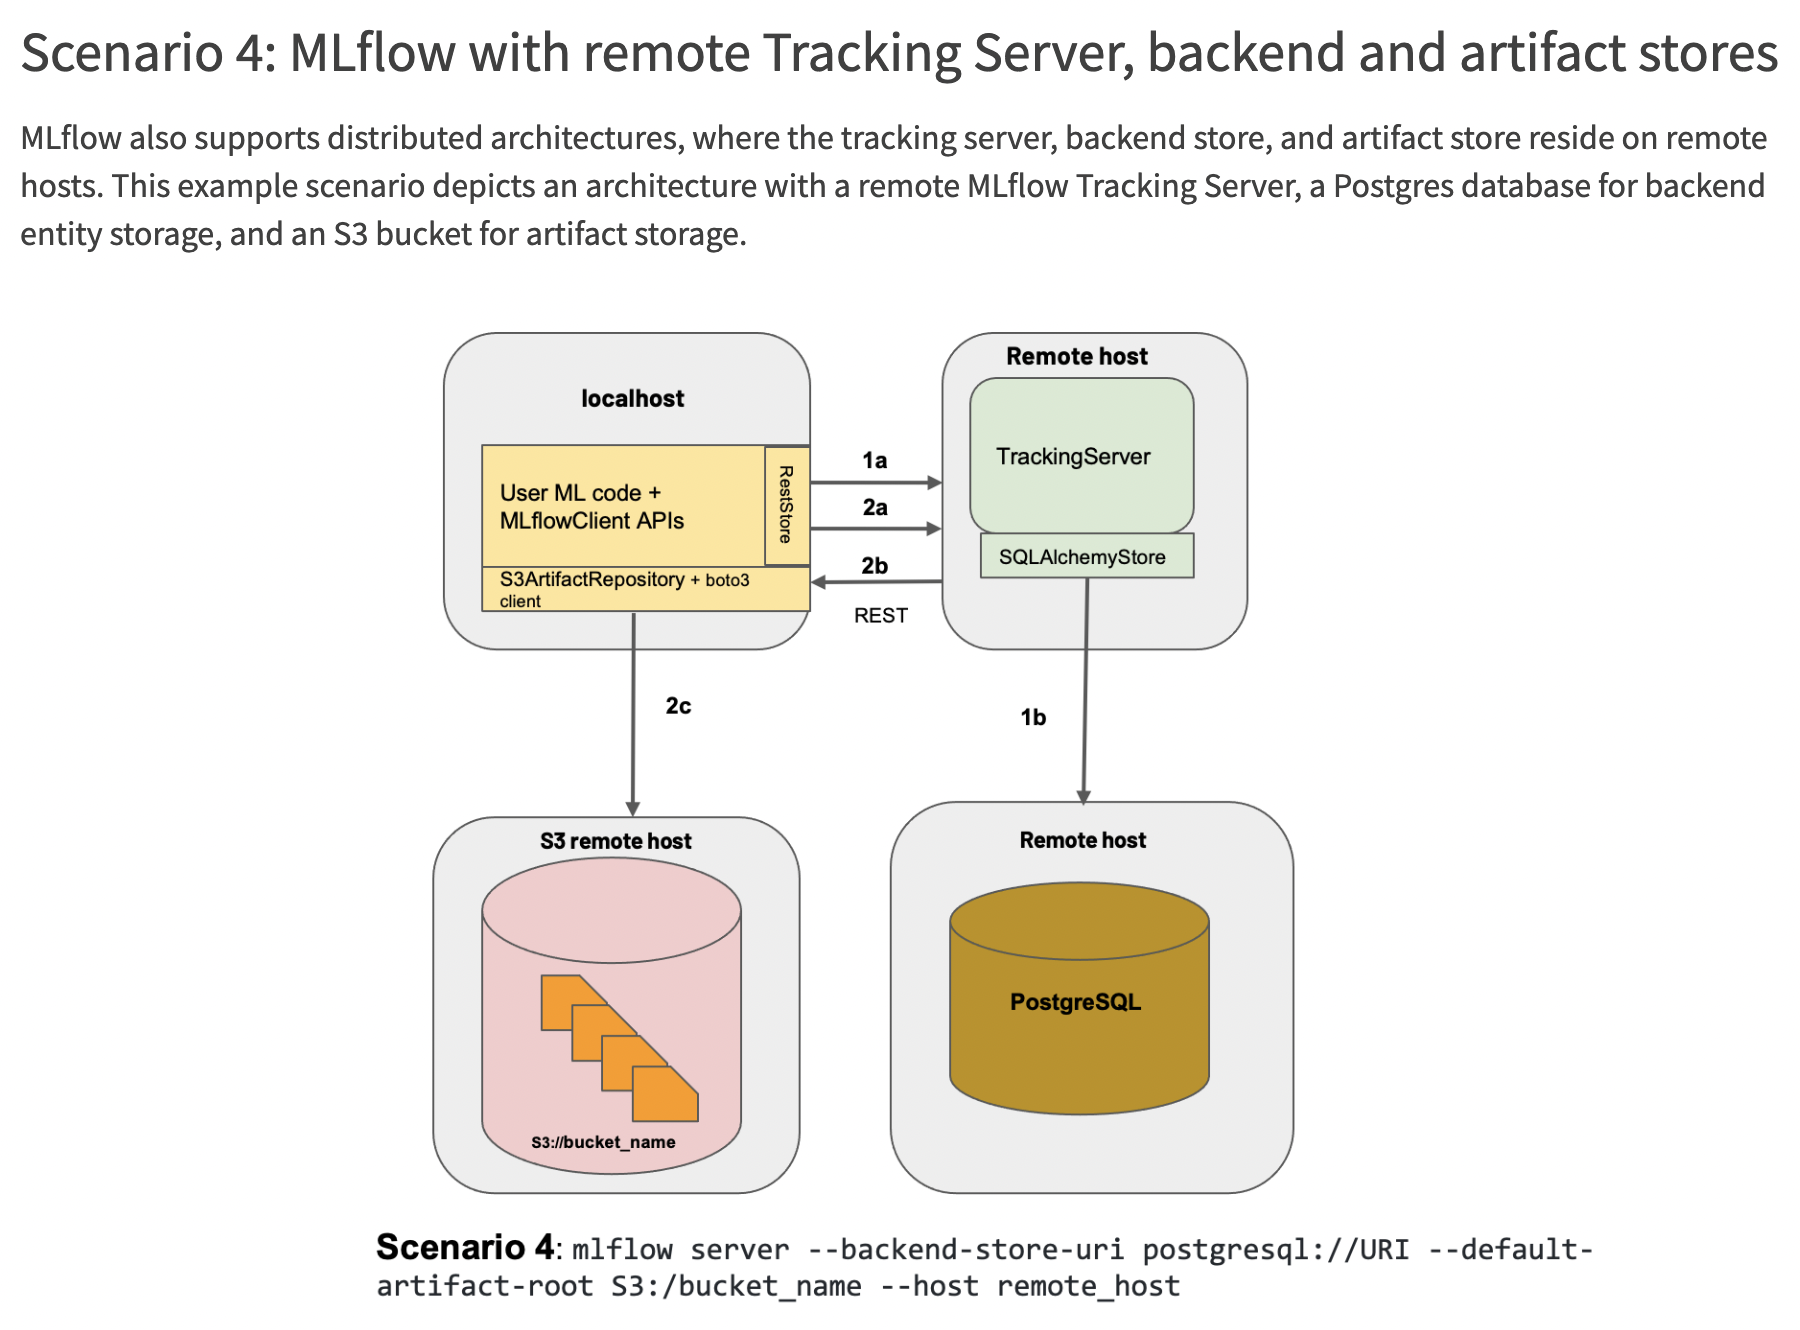

In [40]:
from IPython.display import Image

Image(filename='server.png')

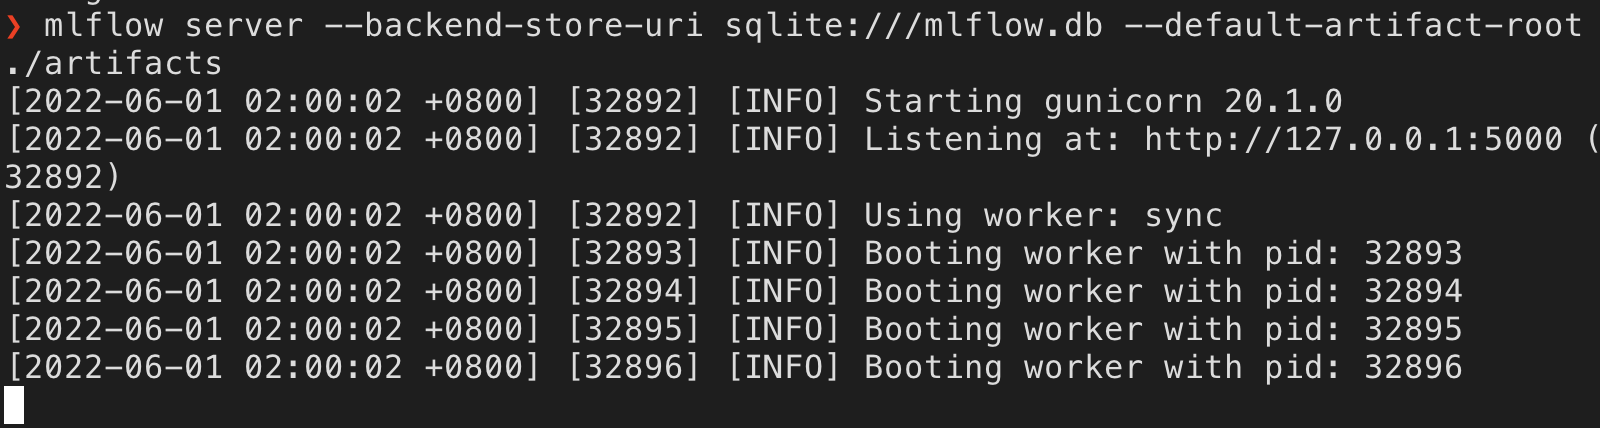

In [42]:
Image(filename='server-2.png')

## Q5

In [44]:
import os
import pickle

import mlflow
import numpy as np
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll import scope
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

data_path = './output'
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("random-forest-hyperopt")


def load_pickle(filename):
    with open(filename, "rb") as f_in:
        return pickle.load(f_in)

X_train, y_train = load_pickle(os.path.join(data_path, "train.pkl"))
X_valid, y_valid = load_pickle(os.path.join(data_path, "valid.pkl"))


def objective(params):

    with mlflow.start_run():

        rf = RandomForestRegressor(**params)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_valid)
        rmse = mean_squared_error(y_valid, y_pred, squared=False)

        mlflow.log_metric('rmse', rmse)

    return {'loss': rmse, 'status': STATUS_OK}
    

search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 1, 20, 1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 10, 50, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 4, 1)),
    'random_state': 42
}


rstate = np.random.default_rng(42)  # for reproducible results

def main():
    fmin(
        fn=objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=50,
        trials=Trials(),
        rstate=rstate
    )

main()

100%|██████████| 50/50 [04:09<00:00,  4.99s/trial, best loss: 6.6284257482044735]


In [45]:
from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_URI = "http://127.0.0.1:5000"
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

client.list_experiments()

[<Experiment: artifact_location='./mlruns/0', experiment_id='0', lifecycle_stage='active', name='Default', tags={}>,
 <Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='hw-taxi-experiment', tags={}>,
 <Experiment: artifact_location='./artifacts/2', experiment_id='2', lifecycle_stage='active', name='random-forest-hyperopt', tags={}>]

In [55]:
runs = client.search_runs(
    experiment_ids=2,
    run_view_type=ViewType.ACTIVE_ONLY,
    order_by=["metrics.rmse ASC"]
)

print(f"{runs[0].data.metrics['rmse']:.3f}")    

6.628


## Q6

In [71]:
import os
import pickle

import mlflow
from hyperopt import hp, space_eval
from hyperopt.pyll import scope
from mlflow.entities import ViewType
from mlflow.tracking import MlflowClient
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

HPO_EXPERIMENT_NAME = "random-forest-hyperopt"
EXPERIMENT_NAME = "random-forest-best-models"

mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.sklearn.autolog()

SPACE = {
    'max_depth': scope.int(hp.quniform('max_depth', 1, 20, 1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 10, 50, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 2, 10, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 4, 1)),
    'random_state': 42
}


X_train, y_train = load_pickle(os.path.join(data_path, "train.pkl"))
X_valid, y_valid = load_pickle(os.path.join(data_path, "valid.pkl"))
X_test, y_test = load_pickle(os.path.join(data_path, "test.pkl"))

def train(params):
    with mlflow.start_run():
        params = space_eval(SPACE, params)
        rf = RandomForestRegressor(**params)
        rf.fit(X_train, y_train)

        # evaluate model on the validation and test sets
        valid_rmse = mean_squared_error(y_valid, rf.predict(X_valid), squared=False)
        mlflow.log_metric("valid_rmse", valid_rmse)
        test_rmse = mean_squared_error(y_test, rf.predict(X_test), squared=False)
        mlflow.log_metric("test_rmse", test_rmse)



def main(log_top):

    client = MlflowClient()

    # retrieve the top_n model runs and log the models to MLflow
    hpo_experiment = client.get_experiment_by_name(HPO_EXPERIMENT_NAME)
    runs = client.search_runs(
        experiment_ids=hpo_experiment.experiment_id,
        run_view_type=ViewType.ACTIVE_ONLY,
        max_results=log_top,
        order_by=["metrics.rmse ASC"]
    )

    for run in runs:
        train(params=run.data.params)

    # select the model with the lowest test RMSE
    experiment = client.get_experiment_by_name(EXPERIMENT_NAME)
    best_run = client.search_runs(experiment_ids=experiment.experiment_id,
        run_view_type=ViewType.ACTIVE_ONLY,
        max_results=log_top,
        order_by=["metrics.test_rmse ASC"]
    )[0]
    
    return best_run

best_run = main(5)

In [70]:
print(f"{best_run.data.metrics['test_rmse']:.2f}")

6.55
